In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import KFold
import os

In [2]:
train_path = 'final_data/train_df.pkl'
train_df = pd.read_pickle(train_path)

test_path = 'final_data/test_df.pkl'
test_df = pd.read_pickle(test_path)

train_df.shape, test_df.shape

((1778619, 6), (443811, 5))

In [3]:
def load_glove_embeddings(filename):
    """Load GloVe embeddings from file."""
    embeddings_index = {}
    with open(filename, encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs
    return embeddings_index

def create_embedding_matrix(word_index, embeddings_index, embedding_dim=200):
    """Create embedding matrix from word index and embeddings."""
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


def preprocess_data(df, tokenizer=None, max_words=80000, max_sequence_length=10000, is_training=True):
    """
    Preprocess the data by grouping tweets by period and tokenizing.
    """
    # Initialize aggregation dictionary with Tweet
    agg_dict = {'Tweet': lambda x: ' '.join(x)}
    
    # Add EventType and MatchID to aggregation if they exist
    if 'EventType' in df.columns and is_training:
        agg_dict['EventType'] = 'first'
    if 'MatchID' in df.columns:
        agg_dict['MatchID'] = 'first'
    
    # Group tweets by ID
    grouped_df = df.groupby('ID').agg(agg_dict).reset_index()
    
    # Create or use existing tokenizer
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=max_words, oov_token='<UNK>')
        tokenizer.fit_on_texts(grouped_df['Tweet'])
    
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(grouped_df['Tweet'])
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
    
    # Prepare outputs
    outputs = [padded_sequences]
    if 'EventType' in grouped_df.columns:
        outputs.append(grouped_df['EventType'].values)
    else:
        outputs.append(None)
    
    outputs.append(tokenizer)
    return tuple(outputs)

In [ ]:
def create_attention_model(vocab_size, embedding_dim, embedding_matrix, max_sequence_length=10000):
    """Create word attention model."""
    # Input layer
    inputs = layers.Input(shape=(max_sequence_length,))
    
    # Embedding layer with pre-trained weights
    embedding_layer = layers.Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        trainable=False
    )(inputs)
    
    # Word-level attention
    attention = layers.Dense(1, use_bias=False)(embedding_layer)
    attention = layers.Flatten()(attention)
    attention_weights = layers.Activation('softmax')(attention)
    attention_weights = layers.RepeatVector(embedding_dim)(attention_weights)
    attention_weights = layers.Permute([2, 1])(attention_weights)
    
    # Apply attention weights to embedding
    merged = layers.Multiply()([embedding_layer, attention_weights])
    merged = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(merged)
    
    dense = layers.Dense(2048, activation='relu')(merged)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(0.5)(dense)
    dense = layers.Dense(128, activation='relu')(dense)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(0.5)(dense)
    dense = layers.Dense(64, activation='relu')(dense)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(0.3)(dense)
    outputs = layers.Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

def get_callbacks(model_prefix):
    """Create callbacks for training."""
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'models/word_attention_glove/{model_prefix}_best_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    return callbacks

In [5]:
def train_ensemble_model(train_df, glove_path, n_splits=5, epochs=50, batch_size=8):
    """Train multiple models using cross-validation based on MatchID."""
    # Create models directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Load GloVe embeddings
    embeddings_index = load_glove_embeddings(glove_path)
    embedding_dim = 200
    
    # Get unique MatchIDs
    unique_matches = train_df['MatchID'].unique()
    
    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Lists to store models and tokenizers
    models = []
    tokenizers = []
    histories = []
    
    # Train models
    for fold, (train_idx, val_idx) in enumerate(kf.split(unique_matches)):
        print(f"\nTraining fold {fold + 1}/{n_splits}")
        
        # Split data based on MatchID
        train_matches = unique_matches[train_idx]
        val_matches = unique_matches[val_idx]
        
        train_data = train_df[train_df['MatchID'].isin(train_matches)]
        val_data = train_df[train_df['MatchID'].isin(val_matches)]
        
        # Preprocess training data
        X_train, y_train, tokenizer = preprocess_data(train_data)
        X_val, y_val, _ = preprocess_data(val_data, tokenizer=tokenizer)
        
        # Create embedding matrix
        embedding_matrix = create_embedding_matrix(
            tokenizer.word_index,
            embeddings_index,
            embedding_dim
        )
        
        # Create and compile model
        model = create_attention_model(
            len(tokenizer.word_index) + 1,
            embedding_dim,
            embedding_matrix
        )
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC()]
        )
        
        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=get_callbacks(f'fold_{fold}'),
            verbose=1
        )
        
        models.append(model)
        tokenizers.append(tokenizer)
        histories.append(history.history)
    
    return models, tokenizers, histories

In [6]:
def save_fold_predictions(models, tokenizers, data_df, output_path, is_train=True):
    """
    Generate and save predictions from each fold model.
    
    Args:
        models: List of trained word attention models
        tokenizers: List of fitted tokenizers
        data_df: DataFrame with ID, Tweet, and MatchID columns
        output_path: Path to save the predictions
        is_train: Boolean indicating if this is training data
    """
    # Group data by period
    grouped_data = data_df.groupby('ID').agg({
        'Tweet': lambda x: ' '.join(x),
        'MatchID': 'first',
        'PeriodID': 'first'
    })
    
    if is_train and 'EventType' in data_df.columns:
        grouped_data['EventType'] = data_df.groupby('ID')['EventType'].first()
    
    grouped_data = grouped_data.reset_index()
    
    # Get predictions from each model
    all_preds = pd.DataFrame({'ID': grouped_data['ID']})
    all_preds['PeriodID'] = grouped_data['PeriodID'].astype(int)
    
    for i, (model, tokenizer) in enumerate(zip(models, tokenizers)):
        X, _, _ = preprocess_data(grouped_data, tokenizer=tokenizer, is_training=True)
        preds = model.predict(X)
        all_preds[f'model_{i}_pred'] = preds.flatten()
    
    # Add true labels for training data
    if is_train and 'EventType' in data_df.columns:
        all_preds['EventType'] = grouped_data['EventType']
    
    # Save predictions
    all_preds.to_csv(output_path, index=False)
    return all_preds


def create_submission(test_predictions_path, meta_classifier, submission_path):
    """
    Create submission file using meta-classifier predictions.
    
    Args:
        test_predictions_path: Path to the saved test predictions
        meta_classifier: Trained XGBoost meta-classifier
        submission_path: Path to save the final submission
    """
    # Load test predictions
    test_meta_features = pd.read_csv(test_predictions_path)
    
    # Get features in correct order
    feature_cols = [col for col in test_meta_features.columns 
                   if col not in ['ID', 'EventType']]
    
    # Make predictions
    final_preds = meta_classifier.predict_proba(test_meta_features[feature_cols])[:, 1]
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'ID': test_meta_features['ID'],
        'EventType': final_preds
    })
    
    # Save submission
    submission_df.to_csv(submission_path, index=False)
    return submission_df

In [7]:
glove_path = "/Users/shash/github/sms/glove.twitter.27B/glove.twitter.27B.200d.txt"

# Step 1: Train word attention models (using your existing code)
models, tokenizers, histories = train_ensemble_model(
    train_df, 
    glove_path=glove_path,
)
print('\nTraining complete!\n')

# Step 2: Generate and save predictions
train_preds = save_fold_predictions(
    models, 
    tokenizers, 
    train_df, 
    'final_features/word_attention_glove/train_predictions.csv', 
    is_train=True
)

test_preds = save_fold_predictions(
    models, 
    tokenizers, 
    test_df, 
    'final_features/word_attention_glove/test_predictions.csv', 
    is_train=False
)

print('\nPredictions saved!\n')


Training fold 1/5
Epoch 1/50
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5360 - auc: 0.5440 - loss: 0.8330
Epoch 1: val_accuracy improved from -inf to 0.53269, saving model to models/word_attention_glove/fold_0_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5361 - auc: 0.5441 - loss: 0.8326 - val_accuracy: 0.5327 - val_auc: 0.6691 - val_loss: 0.6865 - learning_rate: 0.0010
Epoch 2/50
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5599 - auc: 0.5927 - loss: 0.7346
Epoch 2: val_accuracy did not improve from 0.53269
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5601 - auc: 0.5931 - loss: 0.7343 - val_accuracy: 0.5327 - val_auc: 0.7507 - val_loss: 0.6676 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6113 - auc: 0.6651 - loss: 0.6632
Epoch 3: val_accuracy improved from 0.53269 to 0.61538, saving model to models/word_attention_glove/fold_0_best_model.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28

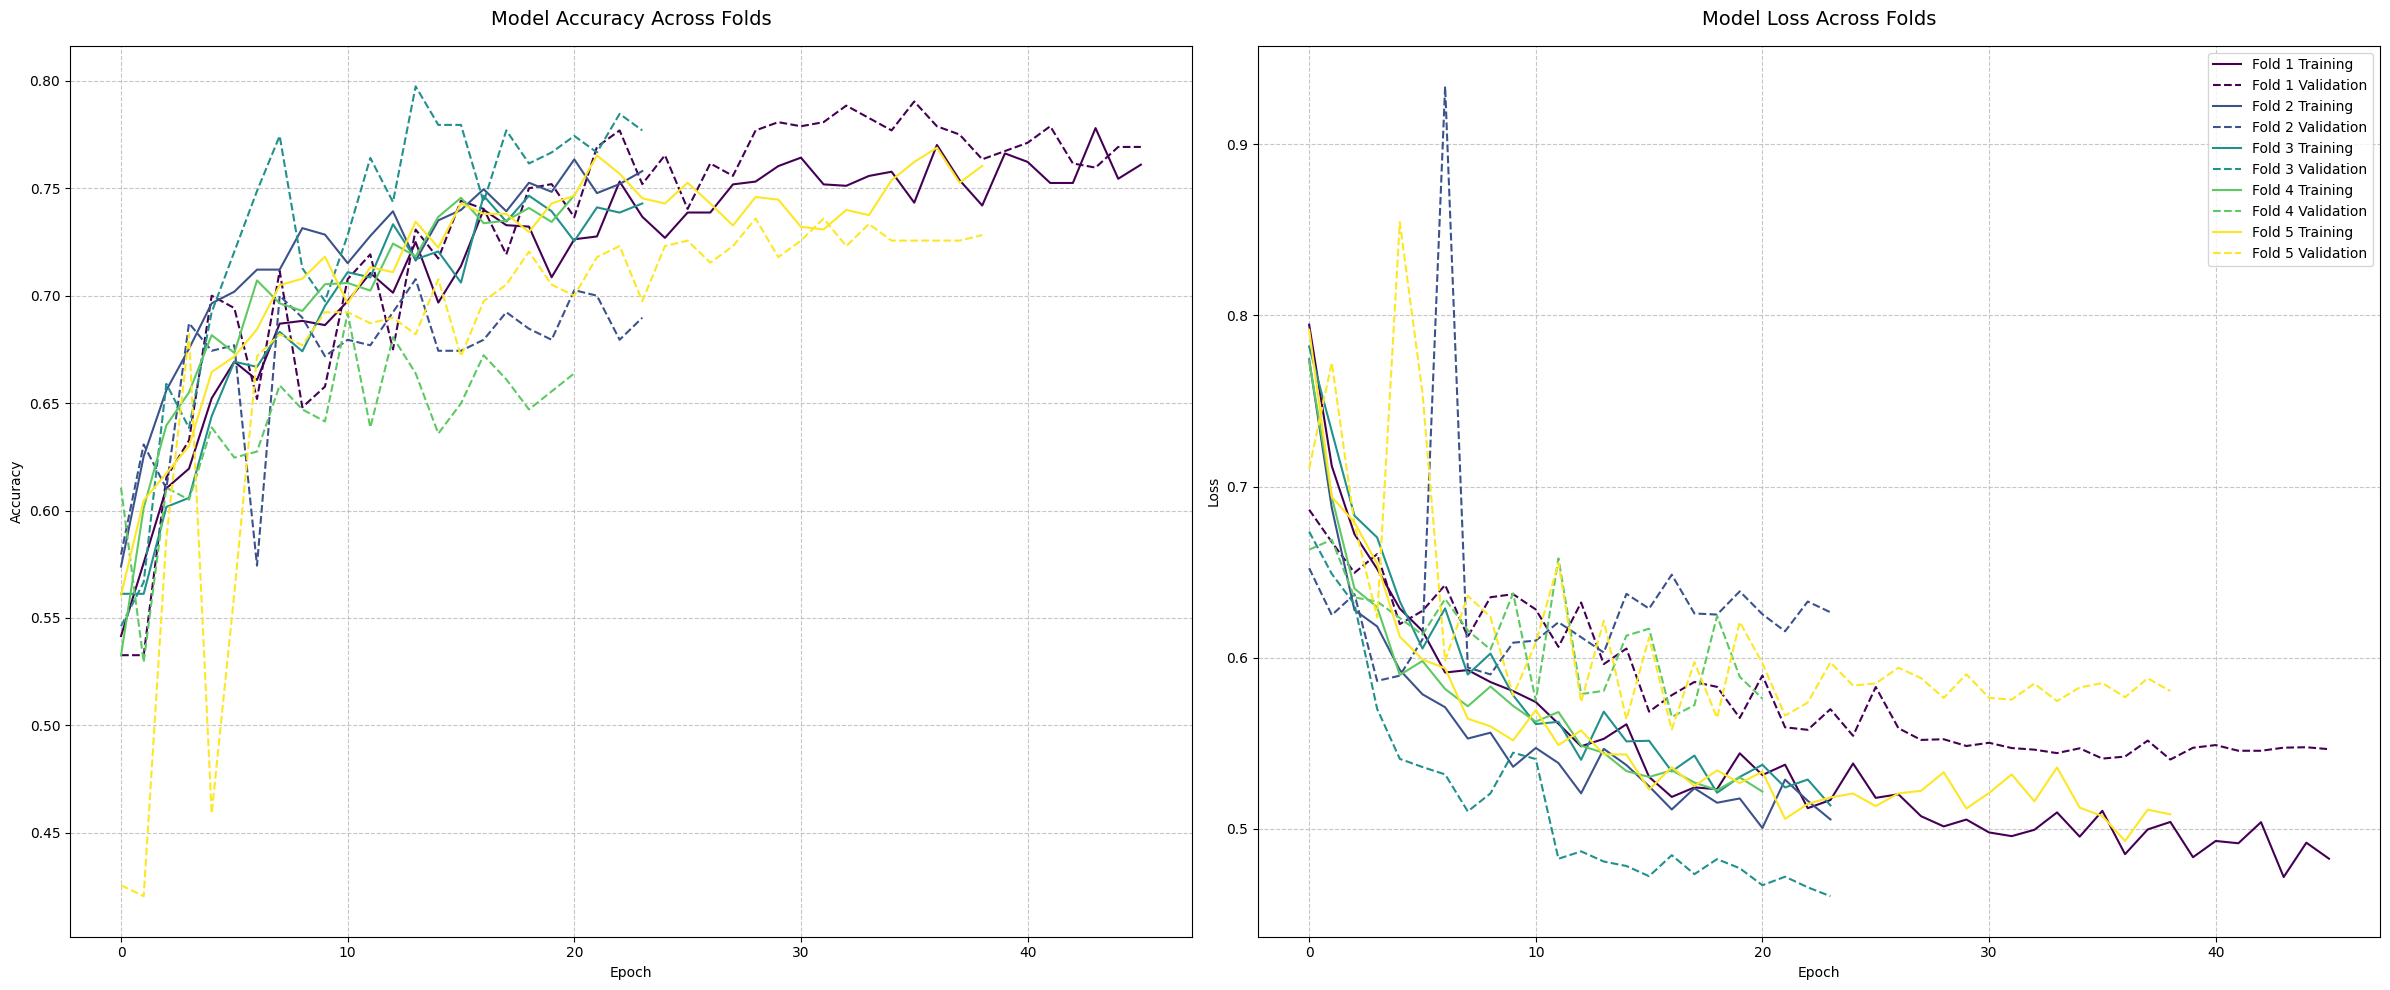

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics(histories):
    """
    Plot training and validation accuracy/loss for all folds.
    
    Args:
        histories: List of training histories from each fold
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    # Colors for different folds
    colors = plt.cm.viridis(np.linspace(0, 1, len(histories)))
    
    # Plot accuracy
    ax1.set_title('Model Accuracy Across Folds', fontsize=14, pad=15)
    for i, history in enumerate(histories):
        ax1.plot(history['accuracy'], color=colors[i], linestyle='-', 
                label=f'Fold {i+1} Training')
        ax1.plot(history['val_accuracy'], color=colors[i], linestyle='--',
                label=f'Fold {i+1} Validation')
    
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.grid(True, linestyle='--', alpha=0.7)
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot loss
    ax2.set_title('Model Loss Across Folds', fontsize=14, pad=15)
    for i, history in enumerate(histories):
        ax2.plot(history['loss'], color=colors[i], linestyle='-',
                label=f'Fold {i+1} Training')
        ax2.plot(history['val_loss'], color=colors[i], linestyle='--',
                label=f'Fold {i+1} Validation')
    
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return fig

# Create and display the plots
fig = plot_training_metrics(histories)
plt.show()